In [2]:
#Importing necessary libraries
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras import optimizers

#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

import string




In [3]:
n_samples = 10000
n_dep = 4
#print list(string.ascii_lowercase)[:n_dep]
df = pd.DataFrame(np.random.rand(n_samples, n_dep), columns=list(string.ascii_lowercase)[:n_dep])

In [4]:
df.head()

,a,b,c,d
0,0.798487,0.731754,0.690493,0.435350
1,0.633203,0.640473,0.256116,0.131151
2,0.087564,0.894408,0.567660,0.838475
3,0.061929,0.605692,0.549532,0.753971
4,0.683949,0.771924,0.174288,0.719329


In [6]:
df["dep1"] = df.a*df.a
df["dep2"] = df.a*df.b
df["dep3"] = 1 - df.c*df.d
#df["dep4"] = 1 + df.a*df.d
#df["dep5"] = 1 - df.b*df.d
#df["dep6"] = 1 - df.b - df.d
df["dep7"] = df.d+2*df.b
df.head()

,a,b,c,d,dep1,dep2,dep3,dep7
0,0.798487,0.731754,0.690493,0.435350,0.637582,0.584296,0.699394,1.898858
1,0.633203,0.640473,0.256116,0.131151,0.400946,0.405549,0.966410,1.412097
2,0.087564,0.894408,0.567660,0.838475,0.007667,0.078318,0.524031,2.627292
3,0.061929,0.605692,0.549532,0.753971,0.003835,0.037510,0.585669,1.965355
4,0.683949,0.771924,0.174288,0.719329,0.467786,0.527956,0.874629,2.263177


In [7]:
if True:
    #Scaling, so that input=output goes from -1 to 1. Otherwise change tanh activation on last layer. 
    from sklearn.preprocessing import StandardScaler
    scaled_features = StandardScaler().fit_transform(df.values)
    scaled_features = scaled_features/4.
    scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
    scaled_features_df.head()
    df= scaled_features_df 

In [8]:
def print_features_histograms(features,target=None):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(8,  2*math.ceil(features.shape[1] / 2.)))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(math.ceil(features.shape[1] / 2.), 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        if target is not None:
            min_value2, max_value2 = np.percentile(target[feature], [1, 99])
            min_value, max_value = min(min_value, min_value2), max(max_value, max_value2)
        min_value-=0.1*max_value
        max_value+=0.2*max_value
        ax.hist(features[feature], range=(min_value, max_value), 
                 label='predicted', **hist_params)
        if target is not None:
            ax.hist(target[feature], range=(min_value, max_value), 
                 label='target', **hist_params)
        ax.set_title(feature)
        



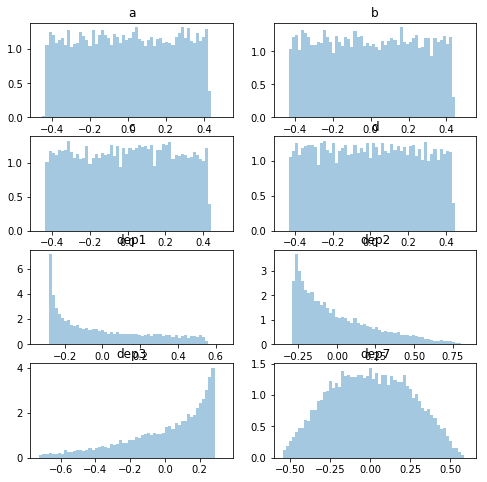

In [9]:
print_features_histograms(df)

In [10]:
# this is the size of our encoded representations
training_frac = 0.7
val_frac      = 0.25


n_train = int(n_samples*training_frac)
n_val = int(n_samples*training_frac*val_frac) # see your code for comparision.

print ("Nb train exmaples " + str(n_train) )
print ("Nb val exmaples " + str(n_val) )

Nb train exmaples 7000
Nb val exmaples 1750


In [11]:
# build simple encoding model using keras 
def create_simple_autoencoder(n_features, encoding_dim, p_drop=0.5):
    inputs = Input(shape=(n_features,))


    # "encoded" is the encoded representation of the input
    """x = Dense(2*n_features, activation='tanh')(inputs)
    x = Dense(2*encoding_dim, activation='tanh')(x)
    x = Dropout(p_drop)(x)"""
    encoded = Dense(encoding_dim, activation='tanh')(inputs)

    # "decoded" is the lossy reconstruction of the input
    """x = Dense(2*encoding_dim, activation='tanh')(encoded)
    x = Dropout(p_drop)(x)
    x = Dense(2*n_features, activation='tanh')(x)"""
    #decoded = Dense(n_features, activation='sigmoid')(encoded)
    decoded = Dense(n_features, activation='tanh')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(inputs, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_n_layers = len(autoencoder.layers) - len(encoder.layers)
    #print "decoder_n_layers : ", decoder_n_layers
    decoder_layers = autoencoder.layers[-decoder_n_layers:]
    decoding = encoded_input
    for i in decoder_layers:
        decoding= i(decoding)


    # create the decoder model
    decoder = Model(encoded_input, decoding)


    optimizer_adam = optimizers.Adam(lr=0.001)

    autoencoder.compile(loss='mse', optimizer=optimizer_adam)
    return autoencoder, encoder, decoder


In [ ]:
l_encoding_dim = [1,2,3,4,5,6,7,8,9,10]
#l_encoding_dim = [8]
l_score = []

train, test = train_test_split(df, random_state=42,train_size=training_frac+val_frac)
train = train.values
test=test.values
nb_epoch = 100
batch_size = 50

early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=5, verbose=3, mode='min')
#tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) you can try to run this visualization

    
for encoding_dim in l_encoding_dim:
    print "encoding_dim : ", encoding_dim

    autoencoder, encoder, decoder = create_simple_autoencoder(df.shape[1], encoding_dim)
    history = autoencoder.fit(train, train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=0,
                    validation_split=val_frac/(training_frac+val_frac)
                    )

    score = autoencoder.evaluate(test, test, batch_size=batch_size)
    #print "\n\nscore : ", score
    l_score.append(score)
    
    encoded_test = encoder.predict(test)
    decoded_test = decoder.predict(encoded_test)
    print_features_histograms(pd.DataFrame(decoded_test), target=pd.DataFrame(test))
    print "\n\n"

encoding_dim :  1
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  2
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  3
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  4
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  5
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  6
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  7
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  8
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  9
 50/500 [==>...........................] - ETA: 0s


encoding_dim :  10


In [ ]:
# The error stops decreasing dramatically after the encoding dimension is the number of independent variables.
plt.plot(l_encoding_dim,l_score)
plt.title("Scores")
plt.xlabel("Encoding dimension")
plt.ylabel("Mean Squared Error")
plt.ylim(0, max(l_score)*1.2)
